#Librerias

In [ ]:
!pip install opencv-python # Instala la librería OpenCV para procesamiento de imágenes
!pip install keras-tuner # Se utiliza para realizar búsqueda automática de hiperparámetros en modelos Keras/TensorFlow.
!pip install --quiet optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 11.2 MB/s eta 0:00:00


In [ ]:
# Librerías del sistema y manejo de archivos
import os
import sys
from os import listdir
from os.path import join

# Librerías para uso en Google Colab
from google.colab import drive

# Librerías para procesamiento numérico y visualización
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

# Librerías para procesamiento y lectura de imágenes
import cv2

# Librerías para machine learning
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import keras_tuner as kt

# Librerías para deep learning
import tensorflow as tf
from tensorflow.keras.metrics import Recall, AUC
from tensorflow.keras.callbacks import ModelCheckpoint ## guardar mejor modelo
from sklearn.metrics import roc_auc_score
import optuna
from sklearn.metrics import recall_score

# Librerías para utilidades adicionales
from tqdm import tqdm  # barra de progreso
import joblib  # para guardar/cargar objetos como modelos o arrays

# Conectar con google drive

In [ ]:
# conectar con Google Drive para acceder a archivos desde Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path="/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones" ### ruta del repositorio en drive
os.chdir(path) ### volver la carpeta del repositorio directorio de trabajo
sys.path.append(path) ### agregarla al path, poder leer archivos de funciones propios como paquetes

In [ ]:
import _funciones as fn #Llamar el archivo de funciones de este proyecto

# Carga de datos procesados

array([[[244, 164, 175],
        [241, 161, 172],
        [243, 162, 171],
        ...,
        [245, 165, 178],
        [241, 163, 176],
        [238, 160, 173]],

       [[244, 163, 171],
        [242, 161, 169],
        [242, 160, 170],
        ...,
        [243, 163, 176],
        [241, 161, 174],
        [238, 158, 171]],

       [[238, 156, 162],
        [239, 158, 164],
        [240, 159, 166],
        ...,
        [242, 162, 175],
        [240, 160, 173],
        [239, 159, 172]],

       ...,

       [[225, 155, 147],
        [226, 155, 148],
        [229, 158, 152],
        ...,
        [223, 150, 157],
        [226, 155, 161],
        [225, 154, 160]],

       [[224, 156, 147],
        [227, 159, 150],
        [228, 159, 152],
        ...,
        [223, 151, 155],
        [227, 156, 160],
        [227, 156, 159]],

       [[226, 158, 149],
        [226, 158, 150],
        [227, 158, 151],
        ...,
        [225, 153, 157],
        [225, 154, 158],
        [223, 152, 156]]], dtype=uint8)
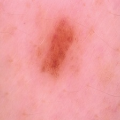

In [ ]:
# Cargar los conjuntos de entrenamiento y prueba ya procesados

x_train = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/X_train.pkl')
y_train = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/y_train.pkl')
x_test = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/X_test.pkl')
y_test = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/y_test.pkl')

x_train[0] # Muestra la primera imagen del conjunto de entrenamiento

## Preprocesamiento de datos

In [ ]:
# Convertir a tipo float para escalar
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [ ]:
x_train.max() # Ver valor máximo
x_train.min() # Ver valor mínimo

np.float32(0.0)

In [ ]:
# Escalar valores entre 0 y 1 con base en el valor máximo
x_train /= 255
x_test  /= 255

In [ ]:
# Verificar dimensiones
x_train.shape
x_test.shape

# Número de variables por imagen
np.prod(x_train[1].shape)

# Ver distribución de clases
np.unique(y_train, return_counts=True)
np.unique(y_test, return_counts=True)

(array([0, 1]), array([322, 258]))

In [ ]:
x_train.shape

(2317, 120, 120, 3)

In [ ]:
x_test.shape

(580, 120, 120, 3)

In [ ]:
y_train.shape

(2317, 1)

In [ ]:
y_test.shape

(580, 1)

# Modelo de red convolucional simple

In [ ]:
# Modelo secuencial, capas apiladas una tras otra
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]), #Capa convolucional 16
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'), #Capa convolucional 32
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'), #Capa convolucional 64
    tf.keras.layers.Dense(1, activation='sigmoid')  # Capa de salida para clasificación binaria (0 o 1) con activación sigmoid
])

#Compilar el modelo con  binary cross-entropy y optimizador de Adam
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC', 'Recall', 'Precision'])

checkpoint = ModelCheckpoint(
    filepath='Salidas/best_cnn_auc.keras',
    monitor='val_AUC',        # Metric must match name used in model.compile()
    mode='max',               # Use 'max' because higher AUC is better
    save_best_only=True,
    verbose=1
)

# Entrenar el modelo
cnn_model.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test), callbacks=checkpoint)

# Resumen del modelo
cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.5280 - Precision: 0.4653 - Recall: 0.5324 - accuracy: 0.5180 - loss: 1.6783
Epoch 1: val_AUC improved from -inf to 0.86086, saving model to Salidas/best_cnn_auc.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - AUC: 0.5302 - Precision: 0.4675 - Recall: 0.5328 - accuracy: 0.5200 - loss: 1.6549 - val_AUC: 0.8609 - val_Precision: 0.9048 - val_Recall: 0.0736 - val_accuracy: 0.5845 - val_loss: 0.6136
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.7898 - Precision: 0.7210 - Recall: 0.5349 - accuracy: 0.6813 - loss: 0.5812
Epoch 2: val_AUC improved from 0.86086 to 0.87345, saving model to Salidas/best_cnn_auc.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - AUC: 0.7900 - Precision: 0.7200 - Recall: 0.5380 - accuracy: 0.6823 - loss: 0.5802 - val_AUC: 0.8734 - val_Precision: 0.8125 - val_Recall: 0.4031 - val_accuracy: 0.6931 - val_loss: 0.5104
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.8421 - Precision: 0.7682 - Reca

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 118, 118, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 57, 57, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,326,533 (73.72 MB)

 Trainable params: 6,442,177 (24.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,884,356 (49.15 MB)

In [ ]:
cnn_best_auc=tf.keras.models.load_model('Salidas/best_cnn_auc.keras')
test_loss_m1, test_acc_m1, test_auc_m1, test_recall_m1, test_precision_m1 = cnn_best_auc.evaluate(x_test, y_test, verbose=2)
print("\n### Resultados Red Convolucional Simple maximizando el AUC ###")
print("Test Accuracy:", test_acc_m1)
print("Test AUC:", test_auc_m1)
print("Test Recall:", test_recall_m1)
print("Test Precision:", test_precision_m1)

19/19 - 5s - 247ms/step - AUC: 0.9357 - Precision: 0.8175 - Recall: 0.8333 - accuracy: 0.8431 - loss: 0.3174

### Resultados Red Convolucional Simple maximizando el AUC ###
Test Accuracy: 0.8431034684181213
Test AUC: 0.9356793761253357
Test Recall: 0.8333333134651184
Test Precision: 0.8174905180931091


La red neuronal convolucional simple, implementada para la detección de cáncer de piel, mostró un desempeño sólido y balanceado tanto en el conjunto de entrenamiento, como en el de validación. El AUC en entrenamiento es de 0.9319 y en validación es de 0.9356, lo que refleja una excelente capacidad discriminativa entre las clases. La precisión (81.09% en entrenamiento y 81.74% en validación) y el recall (85.38% y 83.33%, respectivamente) están en niveles altos y cercanos entre sí, indicando que el modelo, no sólo detecta correctamente la mayoría de los casos positivos, sino que también mantiene un buen equilibrio entre falsos positivos y falsos negativos. La pérdida en validación (0.3174) es ligeramente menor que la de entrenamiento (0.3211), lo cual es normal y no sugiere un subreajuste significativo. El modelo muestra un desempeño sólido y sin señales graves de sobreajuste o subajuste, aunque se trabajará en mejorar la sensibilidad sobre datos de validación, ajustando el umbral de decisión y optimizando hiperparametros como el tamaño del kernel, las unidades densas y el optimizador.

#Ajuste del umbral de decisión

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step
              precision    recall  f1-score   support

           0       0.80      0.92      0.86       322
           1       0.88      0.72      0.79       258

    accuracy                           0.83       580
   macro avg       0.84      0.82      0.83       580
weighted avg       0.84      0.83      0.83       580



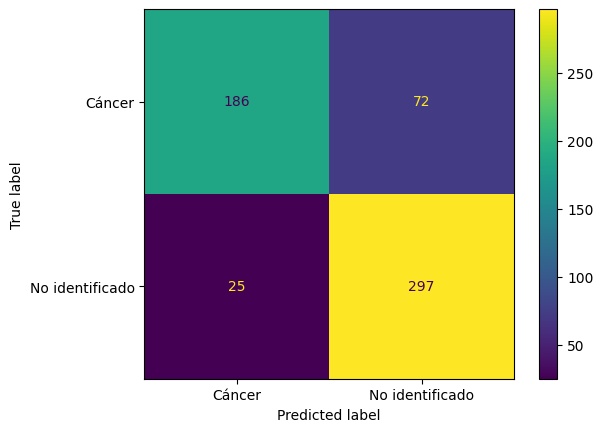

In [ ]:
pred_test = (cnn_best_auc.predict(x_test) > 0.6).astype('int') # Predecir y aplicar umbral de 0.5 para convertir a clase 0 o 1
cm = metrics.confusion_matrix(y_test, pred_test, labels=[1, 0])  # Calcular matriz de confusión
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=['Cáncer', 'No identificado']) # para visualizacion de matriz de confusion
disp.plot()

print(metrics.classification_report(y_test, pred_test)) # reporte con precisión, recall y f1-score

# Afinamiento de hiperparametros

##Hiperparámetros para mejorar el rendimiento en entrenamiento

In [ ]:
# Función objetivo para utilizar optuna
def objective(trial):
    # grilla de huiperparámetros
    kernel_size = trial.suggest_int('kernel_size', 3, 6, step=1)
    dense_units = trial.suggest_int('dense_units', 64, 256,step=32)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd'])

    # Build the model
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(kernel_size, kernel_size), activation='relu', input_shape=x_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(dense_units, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    checkpoint3 = ModelCheckpoint(
    filepath='/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras',
    monitor='val_auc',        # Metric must match name used in model.compile()
    mode='max',               # Use 'max' because higher AUC is better
    save_best_only=True,
    verbose=1)

    #Choose optimizer
    if optimizer_name == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    else:
        opt = tf.keras.optimizers.SGD(learning_rate=0.001)

    # Compile with AUC metric
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=[
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Recall(name='recall')
    ])

    # Train the model
    model.fit(
        x_train, y_train,
        epochs=10,
        validation_data=(x_test, y_test),
        batch_size=100,
        verbose=0,
        callbacks=checkpoint3
    )
    model_win=tf.keras.models.load_model('Salidas/best_cnn_optuna.keras')

    # Predict probabilities and compute AUC manually
    y_pred_prob = model_win.predict(x_test).ravel()
    y_pred_class = (y_pred_prob >= 0.5).astype(int)
    auc = roc_auc_score(y_test, y_pred_prob)
    recall = recall_score(y_test, y_pred_class)
    # Save best model in trial attributes
    trial.set_user_attr("model", model_win)

    return auc

In [ ]:
# Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

# Get best model
best_trial = study.best_trial
best_model = best_trial.user_attrs["model"]

best_model.summary()

[I 2025-05-31 18:58:32,035] A new study created in memory with name: no-name-306afc73-5429-4eb6-a516-6faed81a0754
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_auc improved from -inf to 0.83997, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 2: val_auc improved from 0.83997 to 0.89365, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 3: val_auc improved from 0.89365 to 0.89788, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 4: val_auc did not improve from 0.89788

Epoch 5: val_auc did not improve from 0.89788

Epoch 6: val_auc improved from 0.89788 to 0.90866, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 7: val_auc improved from 0.90866 to 0.92206, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 8: val_auc did not improve from 0.92206

Epoch 9: val_auc did not improve from 0.92206

Epoch 10:

[I 2025-05-31 19:13:00,949] Trial 0 finished with value: 0.928330685155761 and parameters: {'kernel_size': 6, 'dense_units': 192, 'optimizer': 'adam'}. Best is trial 0 with value: 0.928330685155761.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_auc improved from -inf to 0.84625, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 2: val_auc improved from 0.84625 to 0.88060, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 3: val_auc improved from 0.88060 to 0.88454, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 4: val_auc improved from 0.88454 to 0.90102, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 5: val_auc improved from 0.90102 to 0.91484, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 6: val_auc improved from 0.91484 to 0.91721, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 7: val_auc did not improve fro

[I 2025-05-31 19:25:48,381] Trial 1 finished with value: 0.9345418652799846 and parameters: {'kernel_size': 5, 'dense_units': 128, 'optimizer': 'adam'}. Best is trial 1 with value: 0.9345418652799846.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_auc improved from -inf to 0.75265, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 2: val_auc did not improve from 0.75265

Epoch 3: val_auc did not improve from 0.75265

Epoch 4: val_auc did not improve from 0.75265

Epoch 5: val_auc improved from 0.75265 to 0.75680, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 6: val_auc improved from 0.75680 to 0.76237, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 7: val_auc did not improve from 0.76237

Epoch 8: val_auc did not improve from 0.76237

Epoch 9: val_auc did not improve from 0.76237

Epoch 10: val_auc improved from 0.76237 to 0.77504, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step


[I 2025-05-31 19:38:55,643] Trial 2 finished with value: 0.7745678655688767 and parameters: {'kernel_size': 5, 'dense_units': 128, 'optimizer': 'sgd'}. Best is trial 1 with value: 0.9345418652799846.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_auc improved from -inf to 0.76352, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 2: val_auc did not improve from 0.76352

Epoch 3: val_auc did not improve from 0.76352

Epoch 4: val_auc improved from 0.76352 to 0.81801, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 5: val_auc did not improve from 0.81801

Epoch 6: val_auc did not improve from 0.81801

Epoch 7: val_auc improved from 0.81801 to 0.83199, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 8: val_auc did not improve from 0.83199

Epoch 9: val_auc did not improve from 0.83199

Epoch 10: val_auc did not improve from 0.83199
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step


[I 2025-05-31 19:51:44,411] Trial 3 finished with value: 0.8306129327362897 and parameters: {'kernel_size': 5, 'dense_units': 160, 'optimizer': 'sgd'}. Best is trial 1 with value: 0.9345418652799846.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_auc improved from -inf to 0.85004, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 2: val_auc improved from 0.85004 to 0.88745, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 3: val_auc improved from 0.88745 to 0.89572, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 4: val_auc improved from 0.89572 to 0.89804, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 5: val_auc improved from 0.89804 to 0.90613, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 6: val_auc improved from 0.90613 to 0.90998, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 7: val_auc improved from 0.909

[I 2025-05-31 20:04:31,620] Trial 4 finished with value: 0.929125138427464 and parameters: {'kernel_size': 3, 'dense_units': 224, 'optimizer': 'adam'}. Best is trial 1 with value: 0.9345418652799846.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 116, 116, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 58, 58, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,331,141 (73.74 MB)

 Trainable params: 6,443,713 (24.58 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,887,428 (49.16 MB)

In [ ]:
#Imprime el mejor AUC
test_loss_m2, test_auc_m2, test_recall_m2= best_model.evaluate(x_test, y_test)
print(f"\Mejor AUC on test set: {test_auc_m2:.4f}")
print(f"\Mejor Recall on test set: {test_recall_m2:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 248ms/step - auc: 0.9322 - loss: 0.3216 - recall: 0.8990
\Mejor AUC on test set: 0.9346
\Mejor Recall on test set: 0.9147


In [ ]:
best_params = study.best_trial.params
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'kernel_size': 5, 'dense_units': 128, 'optimizer': 'adam'}


#Resumen de indicadores

In [ ]:
# Crear DataFrame con los resultados
resultados = pd.DataFrame({
    "Modelo": ["CNN Simple", "CNN con afinamiento de hiperparámetros"], # Nombres de los modelos
    "AUC": [test_auc_m1,test_auc_m2], # metricas auc de todos los modelos
    "Recall": [test_recall_m1,test_recall_m2] #metricas recall de todos los modelos
})

# Mostrar la tabla ordenada por AUC de mayor a menor
resultados = resultados.sort_values(by="AUC", ascending=False)

# Mostrar tabla sin índice
print(tabulate(resultados, headers='keys', tablefmt='fancy_grid', showindex=False))

╒════════════════════════════════════════╤══════════╤══════════╕
│ Modelo                                 │      AUC │   Recall │
╞════════════════════════════════════════╪══════════╪══════════╡
│ CNN Simple                             │ 0.935679 │ 0.833333 │
├────────────────────────────────────────┼──────────┼──────────┤
│ CNN con afinamiento de hiperparámetros │ 0.934596 │ 0.914729 │
╘════════════════════════════════════════╧══════════╧══════════╛


Finalmente, al comparar los resultados de los dos modelos, se observa un rendimiento sobresaliente en ambos casos en cuanto al AUC, con valores muy similares: 0.9357 para el modelo CNN Simple y 0.9346 para el modelo con afinamiento de hiperparámetros. Esto indica que ambos tienen una excelente capacidad para diferenciar entre casos positivos y negativos de cáncer de piel.

Sin embargo, el modelo afinado presenta un recall más alto (0.9147 frente a 0.8333), lo que refleja una mayor capacidad para identificar correctamente los casos de cáncer. En el contexto de este análisis, esta diferencia es bastante relevante, pues sugiere que el modelo ajustado podría ser más efectivo para reducir falsos negativos y por tanto, más confiable para apoyar las decisiones en la detección automatizada del cáncer de piel.

En comparación con los modelos clásicos evaluados —como Random Forest, red neuronal tradicional, regresión logística, árbol de decisión y KNN— las redes convolucionales (CNN) mostraron un rendimiento claramente superior. El mejor modelo clásico, Random Forest, alcanzó un AUC de 0.8382 y un recall de 0.8566, cifras que fueron superadas por las mejores configuraciones de CNN. Aunque los modelos tradicionales ofrecen resultados aceptables, su capacidad de discriminación y sensibilidad es menor frente al desempeño logrado por las CNN.

# Exportar el mejor modelo

Como se mencionó anteriormente, es más adecuado trabajar con el modelo que incluye afinamiento de hiperparámetros para CNN, debido a su buen desempeño y mayor estabilidad en las dos métricas evaluadas (AUC y recall)

In [ ]:
# Solo si se necesita
best_model.save('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/skin_cancer_model.h5')  # Guardar modelo entrenado